In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hevc_decode_mu
import tqdm

In [2]:
mu = hevc_decode_mu.mu()

In [3]:
target = 10  # The target sojourn time (is this correct?)

In [4]:
target_prob = 0.95  # The reliability, 95% of all jobs should finish withing the target sojourn time (is 95% correct? I think 99.99% might be a little difficult to achieve..)

In [5]:
highway_lambdas = pd.read_csv('roads-lambdas/highway-corso-unita-italia-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x']].set_index('end_time')
industrial_lambdas = pd.read_csv('roads-lambdas/industrial-corso-agneli.json-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x']].set_index('end_time')
lowemission_lambdas = pd.read_csv('roads-lambdas/low-emissions-corso-san-maurizio-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x']].set_index('end_time')
residential_lambdas = pd.read_csv('roads-lambdas/residential-corso-unione-sovietica-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x']].set_index('end_time')

In [6]:
# Replace this with the 'best' apprioximation for that (R, rho) pair.
cdfs = {}
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in np.linspace(0.01, 0.99, 99):
        file = f'sweep-expon/expon-R={R}-rho={round(rho, 2)}.csv'
        cdf = pd.read_csv(file, index_col=0)
        cdfs[(R, round(rho, 2))] = cdf

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


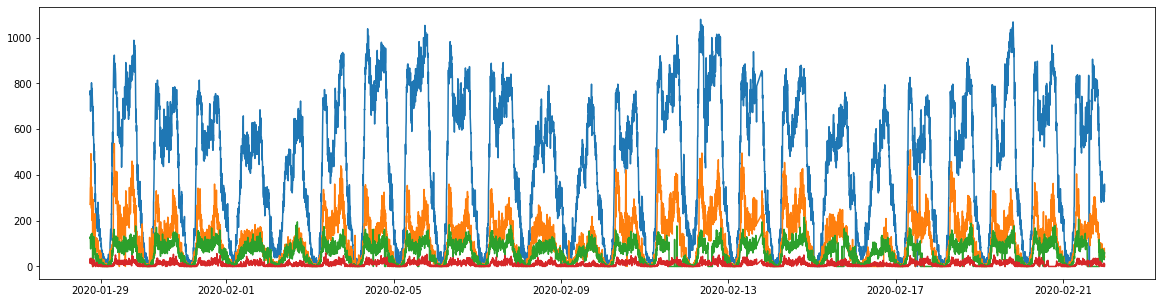

In [7]:
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(highway_lambdas['lambda_v2x'])
ax.plot(industrial_lambdas['lambda_v2x'])
ax.plot(lowemission_lambdas['lambda_v2x'])
ax.plot(residential_lambdas['lambda_v2x'])
plt.show()

In [8]:
def get_percentiles(lmbda, mu, R, p):
    """
    Obtains the pth-percentile for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    percentile = cdf[cdf['cdf'] >= p]['sojourn_time'].min()
    return percentile

In [9]:
for R in tqdm.tqdm_notebook(range(1, 11)):
    highway_lambdas[f'R={R} 99.99th'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    industrial_lambdas[f'R={R} 99.99th'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    lowemission_lambdas[f'R={R} 99.99th'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    residential_lambdas[f'R={R} 99.99th'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))

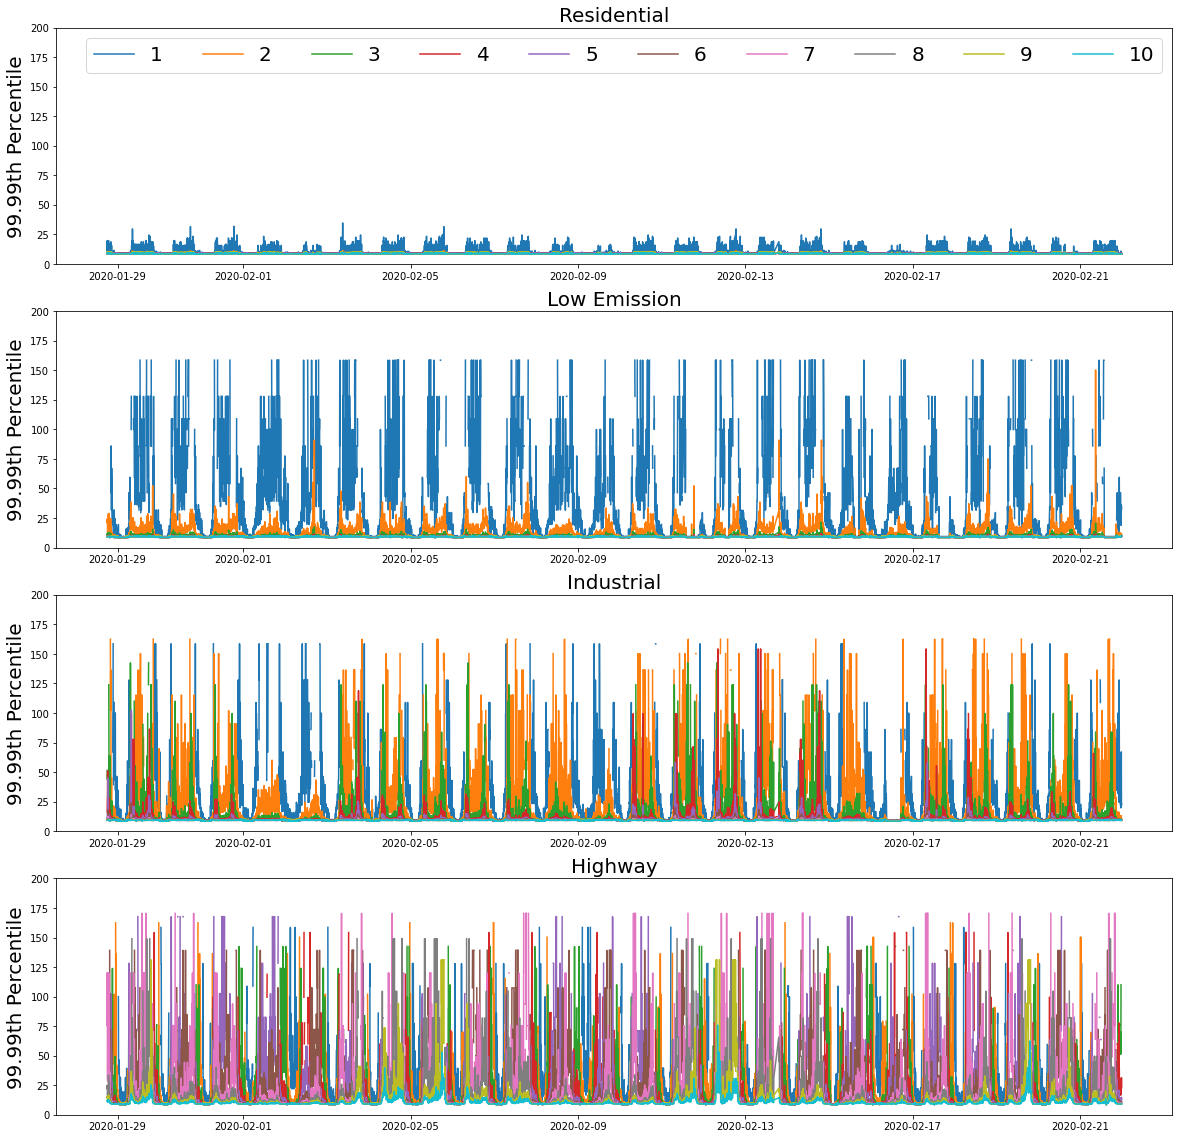

In [10]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} 99.99th'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} 99.99th'])
    axarr[2].plot(industrial_lambdas[f'R={R} 99.99th'])
    axarr[3].plot(highway_lambdas[f'R={R} 99.99th'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel('99.99th Percentile', fontsize=20)
axarr[1].set_ylabel('99.99th Percentile', fontsize=20)
axarr[2].set_ylabel('99.99th Percentile', fontsize=20)
axarr[3].set_ylabel('99.99th Percentile', fontsize=20)
axarr[0].set_ylim(0, 200)
axarr[1].set_ylim(0, 200)
axarr[2].set_ylim(0, 200)
axarr[3].set_ylim(0, 200)
axarr[0].legend(ncol=10, fontsize=20)

In [11]:
def get_prob_exceeding_target(lmbda, mu, R, target):
    """
    Obtains the probability of exceeding the target time for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    prob = 1 - cdf[cdf['sojourn_time'] >= 10]['cdf'].min()
    return prob

In [12]:
for R in tqdm.tqdm_notebook(range(1, 11)):
    highway_lambdas[f'R={R} P(>10)'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    industrial_lambdas[f'R={R} P(>10)'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    lowemission_lambdas[f'R={R} P(>10)'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    residential_lambdas[f'R={R} P(>10)'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))

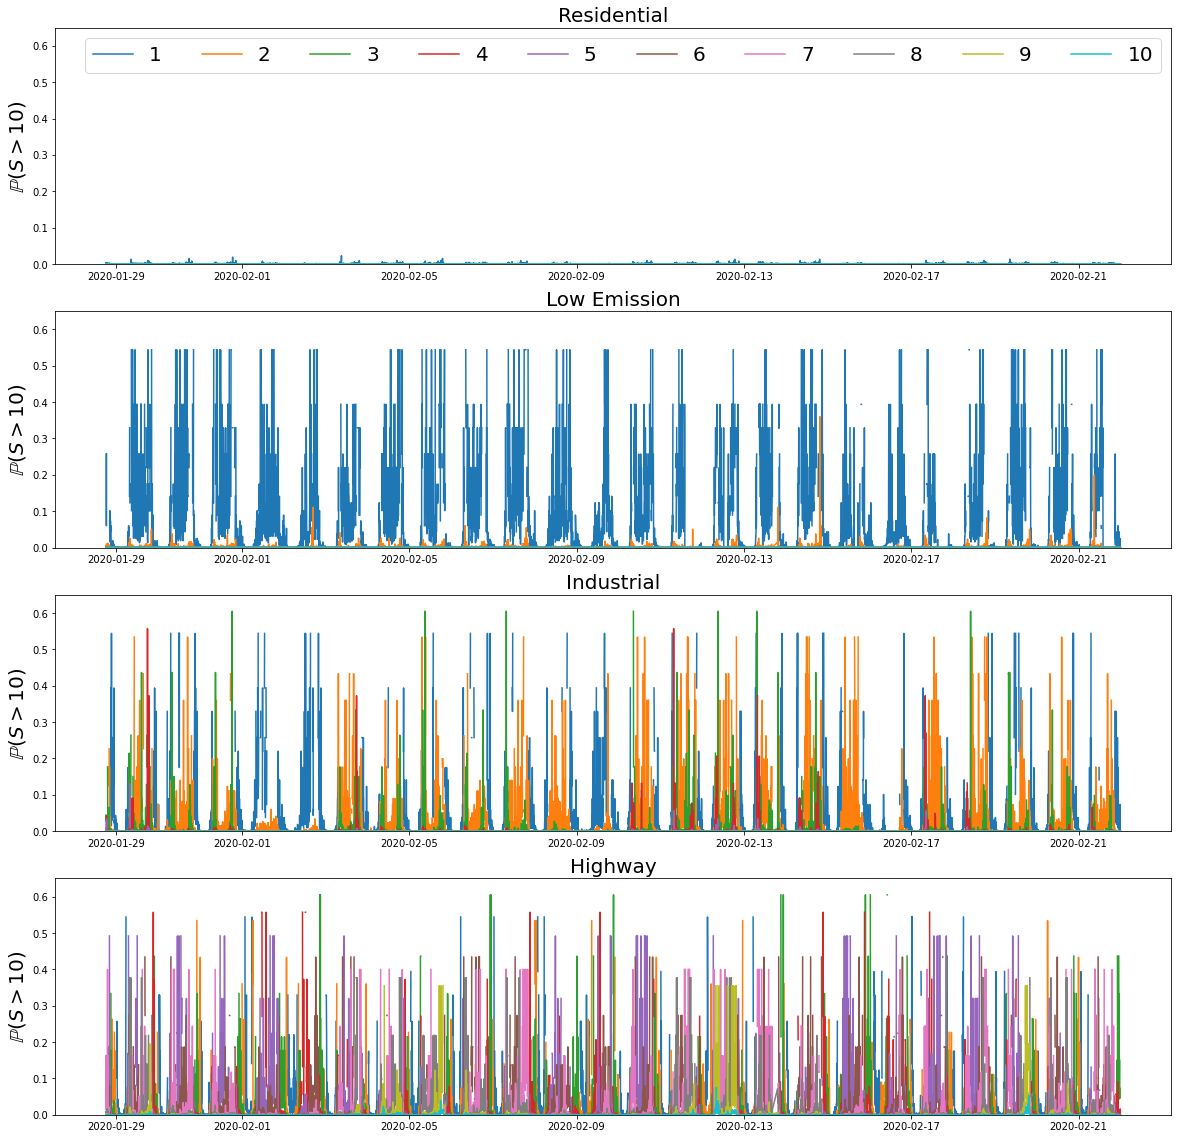

In [13]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} P(>10)'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} P(>10)'])
    axarr[2].plot(industrial_lambdas[f'R={R} P(>10)'])
    axarr[3].plot(highway_lambdas[f'R={R} P(>10)'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[1].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[2].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[3].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[0].set_ylim(0, 0.65)
axarr[1].set_ylim(0, 0.65)
axarr[2].set_ylim(0, 0.65)
axarr[3].set_ylim(0, 0.65)
axarr[0].legend(ncol=10, fontsize=20)

In [14]:
def get_min_R_above_target_prob(row, target_prob):
    ps = row[[f'R={R} P(>10)' for R in range(1, 11)]]
    satisfied_Rs = [R+1 if p < (1 - target_prob) else np.nan for R, p in enumerate(ps)]
    if all(np.isnan(satisfied_Rs)):
        return np.nan
    minR = np.nanmin(satisfied_Rs)
    return minR

In [15]:
highway_lambdas['Best R'] = highway_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
industrial_lambdas['Best R'] = industrial_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
lowemission_lambdas['Best R'] = lowemission_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
residential_lambdas['Best R'] = residential_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)

[]

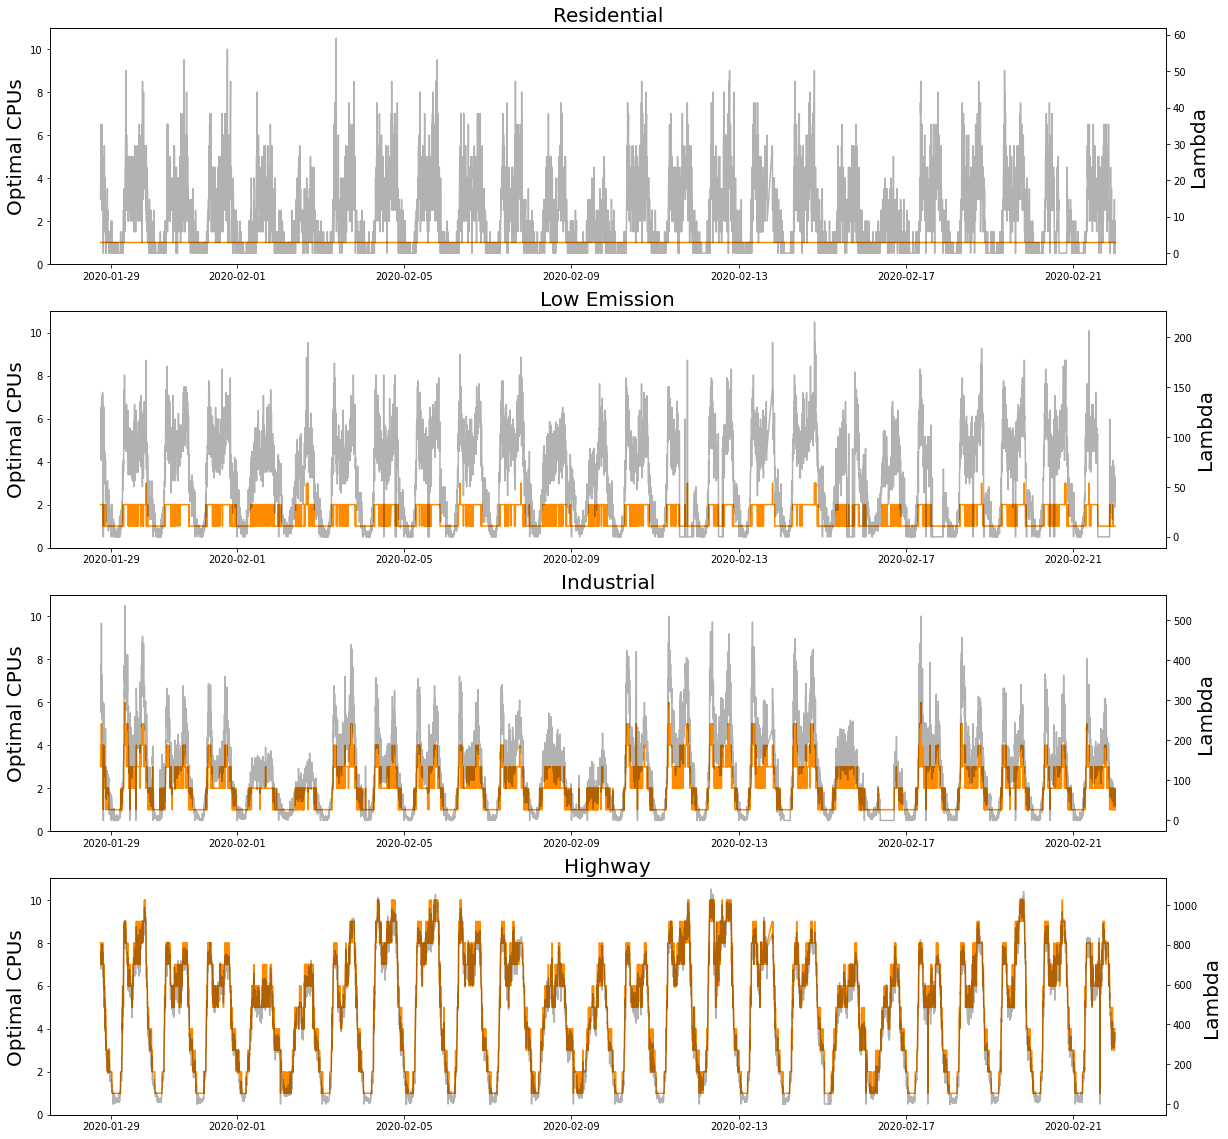

In [16]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
axarr2 = [axarr[i].twinx() for i in range(4)]
axarr2[0].plot(residential_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[1].plot(lowemission_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[2].plot(industrial_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[3].plot(highway_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[0].set_title('Residential', fontsize=20)
axarr2[1].set_title('Low Emission', fontsize=20)
axarr2[2].set_title('Industrial', fontsize=20)
axarr2[3].set_title('Highway', fontsize=20)
axarr[0].plot(residential_lambdas['Best R'], c='darkorange')
axarr[1].plot(lowemission_lambdas['Best R'], c='darkorange')
axarr[2].plot(industrial_lambdas['Best R'], c='darkorange')
axarr[3].plot(highway_lambdas['Best R'], c='darkorange')
for i in range(4):
    axarr[i].set_ylim(0, 11)
    axarr2[i].set_ylabel('Lambda', fontsize=20)
    axarr[i].set_ylabel('Optimal CPUs', fontsize=20)
plt.plot()